Take three outputs of neural network. psi,K and Theta. And see how they behave. 

Basically output psi, theta and K and also add loss terms relating the Outputs of NNs.



In [1]:
import deepxde as dde
from deepxde.backend import torch
import matplotlib.pyplot  as plt
import numpy as np

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
def Gardner(psi, theta_r, theta_s, alpha, K_s):
    K = K_s * torch.exp(alpha * psi)
    theta = theta_r + (theta_s - theta_r) * torch.exp(alpha * psi)
    return theta, K
def VGM(psi, theta_r, theta_s, alpha, K_s):
    """
    this function calculates volumetric water content and hydraulic conductivity
    from matric potential (psi: negative) given VGM (van-Genuchen and Mualem model) parameters
    output: (theta, K)
    theta: volumetric water content
    K: hydraulic conductivity
    By default, alpha, n, and K_s are the parameters to be estiated.
    """
    l = 0.5
    n = 10.4

    m = 1 - 1/n
    S_e = (1 + (-alpha*psi)**n)**(-m)
    theta =  S_e * (theta_s - theta_r) + theta_r
    K = K_s*S_e**l*(1-(1-S_e**(1/m))**m)**2
    return theta, K
# parameter values
alpha = dde.Variable(0.1) # /cm
K_s = dde.Variable(0.1) # cm/hour
theta_s = dde.Variable(0.1)
theta_r = dde.Variable(0.06)
L_star = dde.Variable(10.0) # cm


In [3]:
def plot3D(x,t,y,name="F"):
  x_plot =x.squeeze(1) 
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="terrain")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title(name)
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="terrain")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel(name)
  plt.show()
     
def plot3D_Matrix(x,t,y,name="F"):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title(name)
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel(name)
  plt.show()

In [4]:
def pde(x,y):
    psi = y[:,0:1]
    theta = y[:,1:2]
    K = y[:,2:3]
    theta_t = dde.grad.jacobian(y,x,i=1,j=1)
    psi_z = dde.grad.jacobian(y,x,i=0,j=0)
    psi_zz = dde.grad.hessian(y,x,component=0,i=0,j=0)
    K_z = dde.grad.jacobian(y,x,i=2,j=0)

    residual = theta_t - K_z*psi_z - K*psi_zz - K_z

    Gardner_K = K_s * torch.exp(alpha * psi)
    residual_1 = K - Gardner_K

    Gardner_theta = theta_r + (theta_s - theta_r) * torch.exp(alpha * psi)

    residual_2 = theta - Gardner_theta
    
    return [residual,residual_1,residual_2]  

In [5]:
def output_transform(x,y):
    psi = -torch.exp(y[:,0:1])
    theta = torch.sigmoid(y[:,1:2])
    K = torch.exp(y[:,2:3])

    return torch.hstack((psi,theta,K))

/home/vemuri/anaconda3/envs/newtorch/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


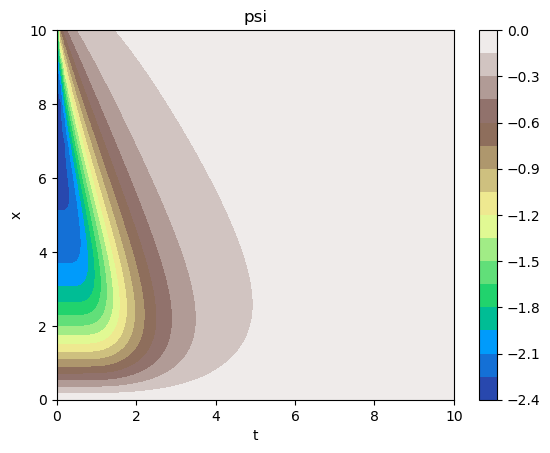

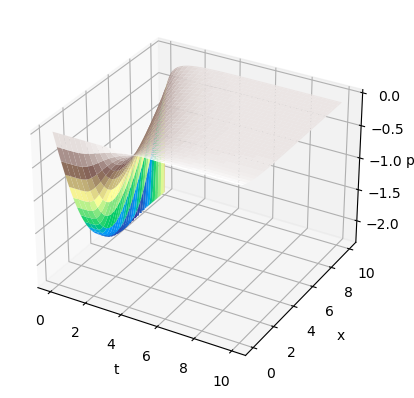

In [6]:
x = np.linspace(0,10,101).reshape((101,1))
t = np.linspace(0,10,101).reshape((101,1))
usol = np.load("Srivastava_psi_homogeneous.npy")
plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(usol),name="psi") 


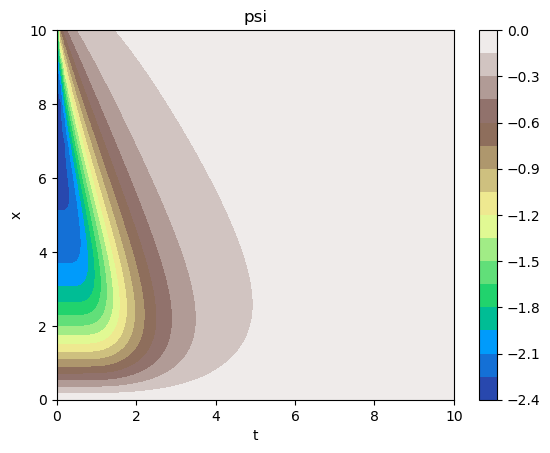

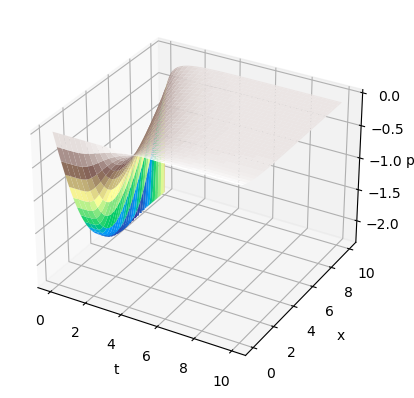

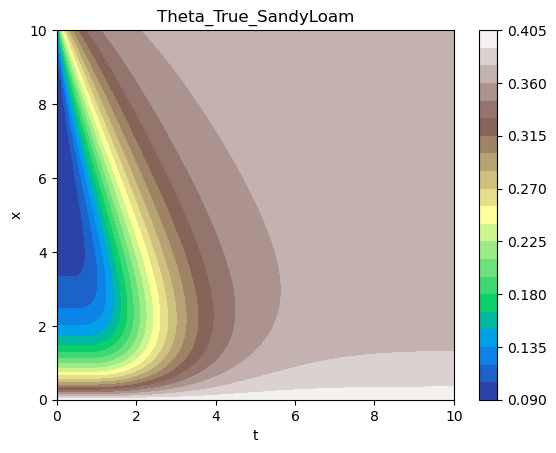

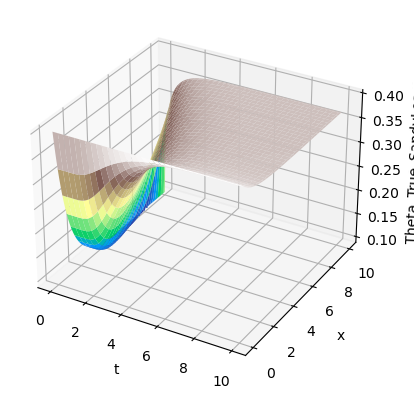

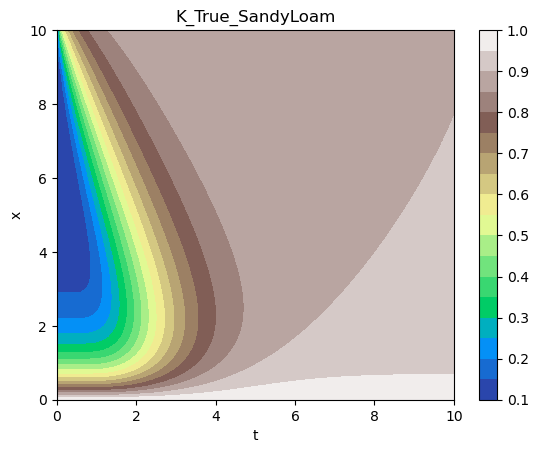

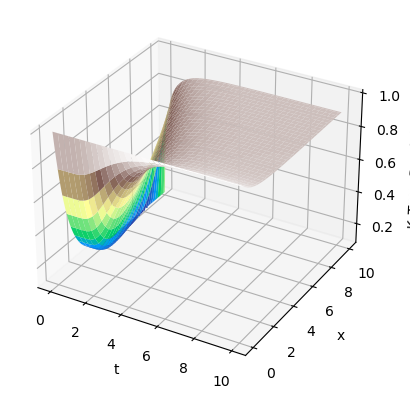

In [7]:
def Gardner_np(psi, theta_r, theta_s, alpha, K_s):
    K = K_s * np.exp(alpha * psi)
    theta = theta_r + (theta_s - theta_r) * np.exp(alpha * psi)
    return theta, K
theta_True,K_True = Gardner_np(usol,0.06,0.4,1.0,1.0)
theta_pred,K_pred = Gardner_np(usol,0.06,0.4,1.0,1.0)

plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(usol),name="psi") 


plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(theta_pred),name="Theta_True_SandyLoam") 

plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(K_pred),name="K_True_SandyLoam") 



In [8]:
torch.cuda.is_available()




True

In [9]:
X, T = np.meshgrid(x,t)   
X_true = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
lb = X_true[0]  # [-1. 0.]
ub = X_true[-1] # [1.  0.99]
U_true = usol.flatten('F')[:,None] #Fortran style (Column Major)


In [10]:
# Obtain random points for interior
id_f = np.random.choice(101*101, 10000, replace=False)# Randomly chosen points for Interior
X_train = X_true[id_f]
U_train= U_true[id_f]

print("We have",101*101,"points. We will select",X_train.shape[0],"points to train our model.")

We have 10201 points. We will select 10000 points to train our model.


In [11]:
geom = dde.geometry.Interval(0, 10)
timedomain = dde.geometry.TimeDomain(0, 10)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [12]:
observe_y = dde.icbc.PointSetBC(X_train, U_train,component=0)

In [13]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [observe_y],
    num_domain=100,
    num_boundary=100,
    num_initial=100,
    anchors=X_train,
)

In [14]:
layer_size = [2] + [50] * 6 + [3]
activation = "swish"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)


In [15]:
# callbacks for storing results
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue([alpha], period=100, filename=fnamevar)

# Compile, train and save model
model.compile("adam", lr=1e-3)
loss_history, train_state = model.train(
    iterations=20000 ,display_every=1000, disregard_previous_best=True
)

Compiling model...
'compile' took 0.000753 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [4.29e-04, 8.84e-01, 1.26e-02, 3.58e-01]    [4.29e-04, 8.84e-01, 1.26e-02, 3.58e-01]    []  
1000      [4.44e-04, 2.09e-04, 2.17e-04, 5.52e-04]    [4.44e-04, 2.09e-04, 2.17e-04, 5.52e-04]    []  
2000      [4.31e-04, 6.77e-05, 2.16e-04, 2.70e-04]    [4.31e-04, 6.77e-05, 2.16e-04, 2.70e-04]    []  
3000      [4.13e-04, 5.01e-05, 2.29e-04, 1.46e-04]    [4.13e-04, 5.01e-05, 2.29e-04, 1.46e-04]    []  
4000      [4.07e-04, 4.71e-05, 2.13e-04, 8.95e-05]    [4.07e-04, 4.71e-05, 2.13e-04, 8.95e-05]    []  
5000      [3.95e-04, 7.57e-05, 2.08e-04, 6.83e-05]    [3.95e-04, 7.57e-05, 2.08e-04, 6.83e-05]    []  
6000      [4.08e-04, 4.46e-05, 2.08e-04, 6.32e-05]    [4.08e-04, 4.46e-05, 2.08e-04, 6.32e-05]    []  
7000      [4.04e-04, 4.64e-05, 2.06e-04, 5.79e-05]    [4.04e-04, 4.64e-05, 2.06e-04, 5.79e-05]    []  
8

In [16]:
Preds = model.predict(X_true)

In [22]:
psi_preds.reshape((101,101))

array([[-5.96188009e-03, -9.58561003e-02, -1.84753314e-01, ...,
        -2.24285746e+00, -2.20015240e+00, -2.14840364e+00],
       [-3.55165638e-03, -9.31254104e-02, -1.81688577e-01, ...,
        -9.73647237e-01, -8.80911887e-01, -7.92154908e-01],
       [-1.82352215e-03, -9.11483020e-02, -1.79455280e-01, ...,
        -6.52529955e-01, -6.03442550e-01, -5.57623684e-01],
       ...,
       [-2.07765214e-03, -1.13452598e-02, -1.98374484e-02, ...,
        -1.04790568e-01, -1.04730904e-01, -1.04670718e-01],
       [-2.36764736e-03, -1.16149550e-02, -2.00875811e-02, ...,
        -1.04784712e-01, -1.04724139e-01, -1.04662813e-01],
       [-2.67046690e-03, -1.18972370e-02, -2.03502886e-02, ...,
        -1.04779176e-01, -1.04717717e-01, -1.04655728e-01]], dtype=float32)

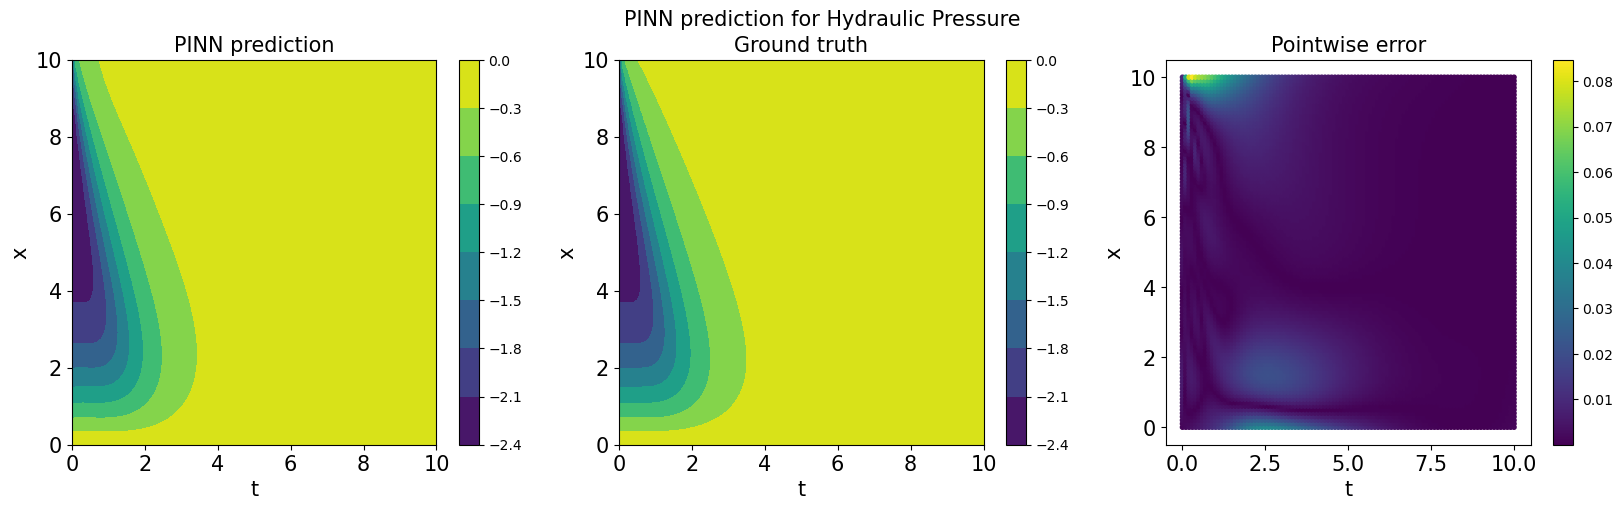

In [17]:
psi_preds= Preds[:,0]
theta_preds= Preds[:,1]
K_preds = Preds[:,2]


#psi_reshaped_preds = psi_preds.reshape((100,100))

fig, ax = plt.subplots(1,3,figsize=(20,5))

im0=ax[0].contourf(T,X,psi_preds.reshape((101,101)),vmin=-2.4,vmax=0.0)
fig.colorbar(im0)
ax[0].set_title("PINN prediction",fontsize=15)
ax[0].set_xlabel("t",fontsize=15)
ax[0].set_ylabel("x",fontsize=15)

im1 = ax[1].contourf(T,X,U_true.reshape((101,101)),vmin=-2.4,vmax=0.0)
fig.colorbar(im1)

im2 = ax[2].scatter(X_true[:,1],X_true[:,0],c =np.abs((U_true[:,0]-psi_preds)),marker=".",s=None)
fig.colorbar(im2)
ax[1].set_title("Ground truth",fontsize=15)
ax[1].set_xlabel("t",fontsize=15)
ax[1].set_ylabel("x",fontsize=15)
ax[2].set_title("Pointwise error",fontsize=15)
ax[2].set_xlabel("t",fontsize=15)
ax[2].set_ylabel("x",fontsize=15)
ax[0].xaxis.set_tick_params(labelsize=15)
ax[0].yaxis.set_tick_params(labelsize=15)
ax[1].xaxis.set_tick_params(labelsize=15)
ax[1].yaxis.set_tick_params(labelsize=15)
ax[2].xaxis.set_tick_params(labelsize=15)
ax[2].yaxis.set_tick_params(labelsize=15)
fig.suptitle("PINN prediction for Hydraulic Pressure",fontsize=15)
fig.savefig("GardnerPsi.pdf",dpi=500)


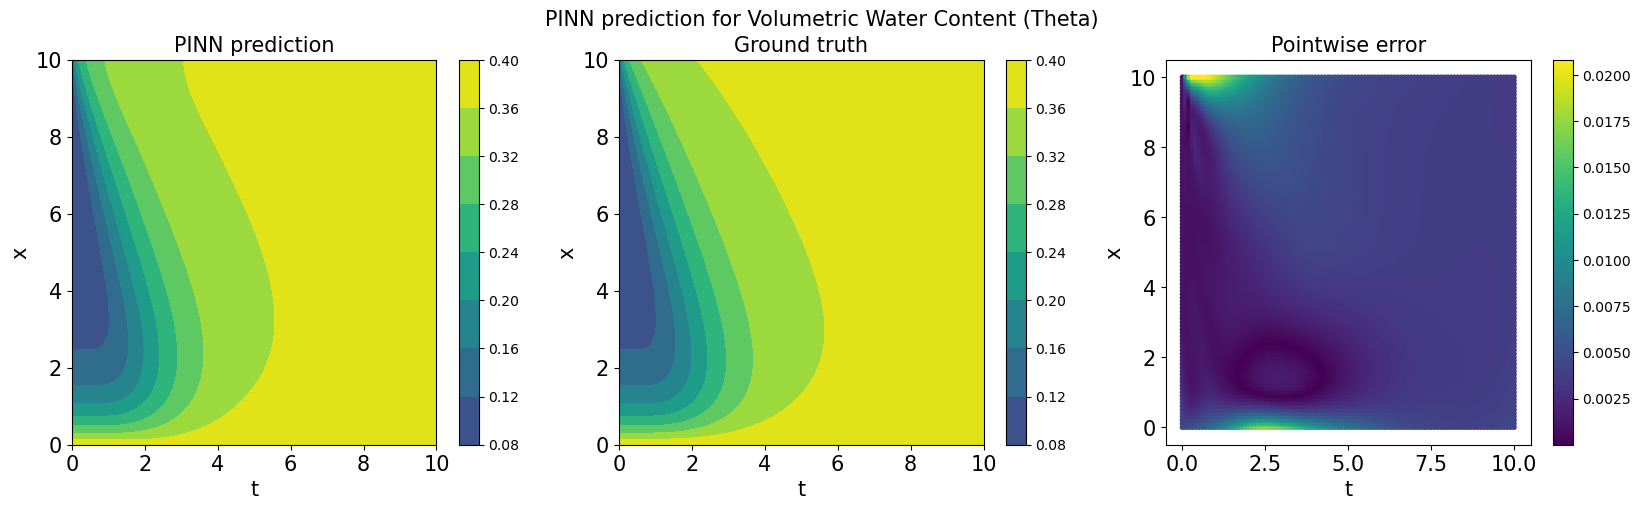

In [24]:
import numpy as np
def Gardner(psi, theta_r=0.06, theta_s=0.4, alpha=1.00, K_s=1.0):
    K = K_s * np.exp(alpha * psi)
    theta = theta_r + (theta_s - theta_r) * np.exp(alpha * psi)
    return theta, K

theta, K = Gardner(U_true)
theta_pred,K_pred =Gardner (psi_preds) 
fig, ax = plt.subplots(1,3,figsize=(20,5))

im0=ax[0].contourf(T,X,theta_pred.reshape((101,101)),vmin=0,vmax=0.4)
fig.colorbar(im0)


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
im1 = ax[1].contourf(T,X,theta.reshape((101,101)),vmin=0,vmax=0.4)
fig.colorbar(im1)

im2 = ax[2].scatter(X_true[:,1],X_true[:,0],c =np.abs((theta[:,0]-0.99*theta_pred)),marker=".",s=None)
fig.colorbar(im2)
ax[0].set_title("PINN prediction",fontsize=15)
ax[0].set_xlabel("t",fontsize=15)
ax[0].set_ylabel("x",fontsize=15)
ax[1].set_title("Ground truth",fontsize=15)
ax[1].set_xlabel("t",fontsize=15)
ax[1].set_ylabel("x",fontsize=15)
ax[2].set_title("Pointwise error",fontsize=15)
ax[2].set_xlabel("t",fontsize=15)
ax[2].set_ylabel("x",fontsize=15)

ax[0].xaxis.set_tick_params(labelsize=15)
ax[0].yaxis.set_tick_params(labelsize=15)
ax[1].xaxis.set_tick_params(labelsize=15)
ax[1].yaxis.set_tick_params(labelsize=15)
ax[2].xaxis.set_tick_params(labelsize=15)
ax[2].yaxis.set_tick_params(labelsize=15)
fig.suptitle("PINN prediction for Volumetric Water Content (Theta)",fontsize=15)
fig.savefig("GardnerTheta.pdf",dpi=500)

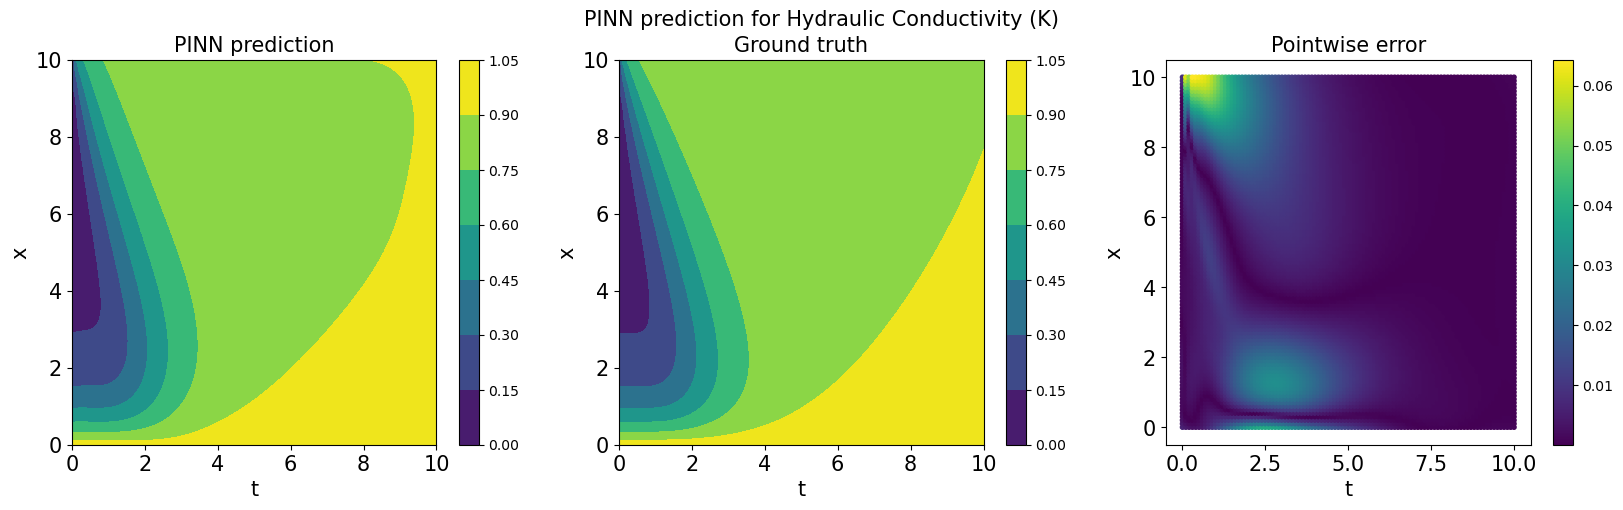

In [22]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

im0=ax[0].contourf(T,X,K_preds.reshape((101,101)),vmin=0,vmax=1.0)
fig.colorbar(im0)


im1 = ax[1].contourf(T,X,K.reshape((101,101)),vmin=0,vmax=1.0)
fig.colorbar(im1)

im2 = ax[2].scatter(X_true[:,1],X_true[:,0],c =np.abs((K[:,0]-K_preds)),marker=".",s=None)
fig.colorbar(im2)


ax[0].set_title("PINN prediction",fontsize=15)
ax[0].set_xlabel("t",fontsize=15)
ax[0].set_ylabel("x",fontsize=15)

ax[1].set_title("Ground truth",fontsize=15)
ax[1].set_xlabel("t",fontsize=15)
ax[1].set_ylabel("x",fontsize=15)
ax[2].set_title("Pointwise error",fontsize=15)
ax[2].set_xlabel("t",fontsize=15)
ax[2].set_ylabel("x",fontsize=15)
ax[0].xaxis.set_tick_params(labelsize=15)
ax[0].yaxis.set_tick_params(labelsize=15)
ax[1].xaxis.set_tick_params(labelsize=15)
ax[1].yaxis.set_tick_params(labelsize=15)
ax[2].xaxis.set_tick_params(labelsize=15)
ax[2].yaxis.set_tick_params(labelsize=15)

fig.suptitle("PINN prediction for Hydraulic Conductivity (K)",fontsize=15)
fig.savefig("GardnerK.pdf",dpi=500)